In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from itertools import chain
from datetime import datetime
from collections import defaultdict
import pytz
import us

import numpy as np
import pandas as pd
from scipy.stats import norm
from matplotlib import pyplot as plt
%matplotlib inline

from covid.data import load_cal_cases_data, load_cal_hosps_data
from covid.cal_hosps import CalHospsModel, load_data
from covid.run import *

In [106]:
start_date = '2020-08-15'
today = pd.to_datetime(f"{datetime.now(pytz.timezone('US/Pacific')):%Y-%m-%d}")
# end_date = f"{today - pd.Timedelta((today.weekday()-6)%7, unit='d'):%Y-%m-%d}"
end_date = '2020-12-07'
cond_size = 14
pred_size = 7
test_size = 7
n_rolls = 4
d_hidden = 32
n_epochs = 600
share_params = False
full_attention = False
symmetric = False
# quantiles = (0.01, 0.025) + tuple([0.05*i for i in range(1,11)])
quantiles = (0.05,0.5)
var_penalty = 0.0
device = 1

model_path = Path(f'dumps/cal/hosps')
model_path.mkdir(parents=True, exist_ok=True)

In [107]:
train_data, valid_data = load_data(
    start_date = start_date,
    end_date = end_date,
    device = device,
    test_size = test_size,
)

In [108]:
past = load_cal_hosps_data(
    confirmed=None, icu = False,
    start_date=f"{pd.to_datetime(end_date)-pd.Timedelta(10*7, unit='d'):%Y-%m-%d}", 
    end_date=end_date,
)
real = load_cal_hosps_data(
    confirmed=None, icu = False,
    start_date=end_date, 
    end_date=f"{pd.to_datetime(end_date)+pd.Timedelta(4*7, unit='d'):%Y-%m-%d}",
)
fips = pd.read_csv('covid/data/cal_fips.tsv', sep='\t', index_col=0)

In [109]:
seed = 42
pt.manual_seed(seed)
n_location = 56
model = CalHospsModel(
    cond_size, pred_size, n_rolls, d_hidden, n_location, quantiles,
    d_feats=0, 
    share_params=share_params,
    full_attention=full_attention,
    var_penalty=var_penalty,
).cuda(device)
optimizer = Adam([
    {'params': chain(model.hosps_smoother.parameters(), model.cases_smoother.parameters()), 'lr': 1e-2},
    {'params': [p for n, p in model.named_parameters() if 'smoother' not in n], 'lr': 1e-3}
])

In [49]:
train(
    train_data,
    valid_data,
    model,
    optimizer,
    model_path=model_path.joinpath(f"hosps-{seed}-{end_date}.pkl"),
    n_epochs=n_epochs,
    test_size=test_size,
    patience=30,
)

100%|██████████| 600/600 [01:35<00:00,  6.30epoch/s, train_loss=12.2, valid_loss=3.12]  


In [110]:
model.attention.temperature = 0.4

In [111]:
pr = inference(
    valid_data if valid_data is not None else train_data, 
    model, 
    model_path.joinpath(f"hosps-{seed}-{end_date}.pkl"),
)

In [112]:
mid_pr = pd.DataFrame(
    data=pr[:,0,len(quantiles)-1].cpu().numpy().astype(np.int64).T,
    index=pd.date_range(start=end_date, periods=4*7, freq='d'),
    columns=real.columns,
)
low_pr = pd.DataFrame(
    data=pr[:,0,0].cpu().numpy().astype(np.int64).T,
    index=pd.date_range(start=end_date, periods=4*7, freq='d'),
    columns=real.columns,
)
high_pr = pd.DataFrame(
    data=pr[:,0,-1].cpu().numpy().astype(np.int64).T,
    index=pd.date_range(start=end_date, periods=4*7, freq='d'),
    columns=real.columns,
)
smoothed_hosps = pd.DataFrame(
    data=model.smoothed_hosps.cpu().numpy().T[-past.shape[0]:],
    index=past.index,
    columns=past.columns
)
local_pr = pd.DataFrame(
    data=model.hosps_local_pr.cpu().numpy()[:,-1].T,
    index=pd.date_range(start=end_date, periods=4*7, freq='d'),
    columns=real.columns
)
smoothed_pr = pd.DataFrame(
    data=model.smoothed_pr.cpu().numpy()[:,0,len(quantiles)-1].T,
    index=pd.date_range(start=end_date, periods=4*7, freq='d'),
    columns=real.columns
)

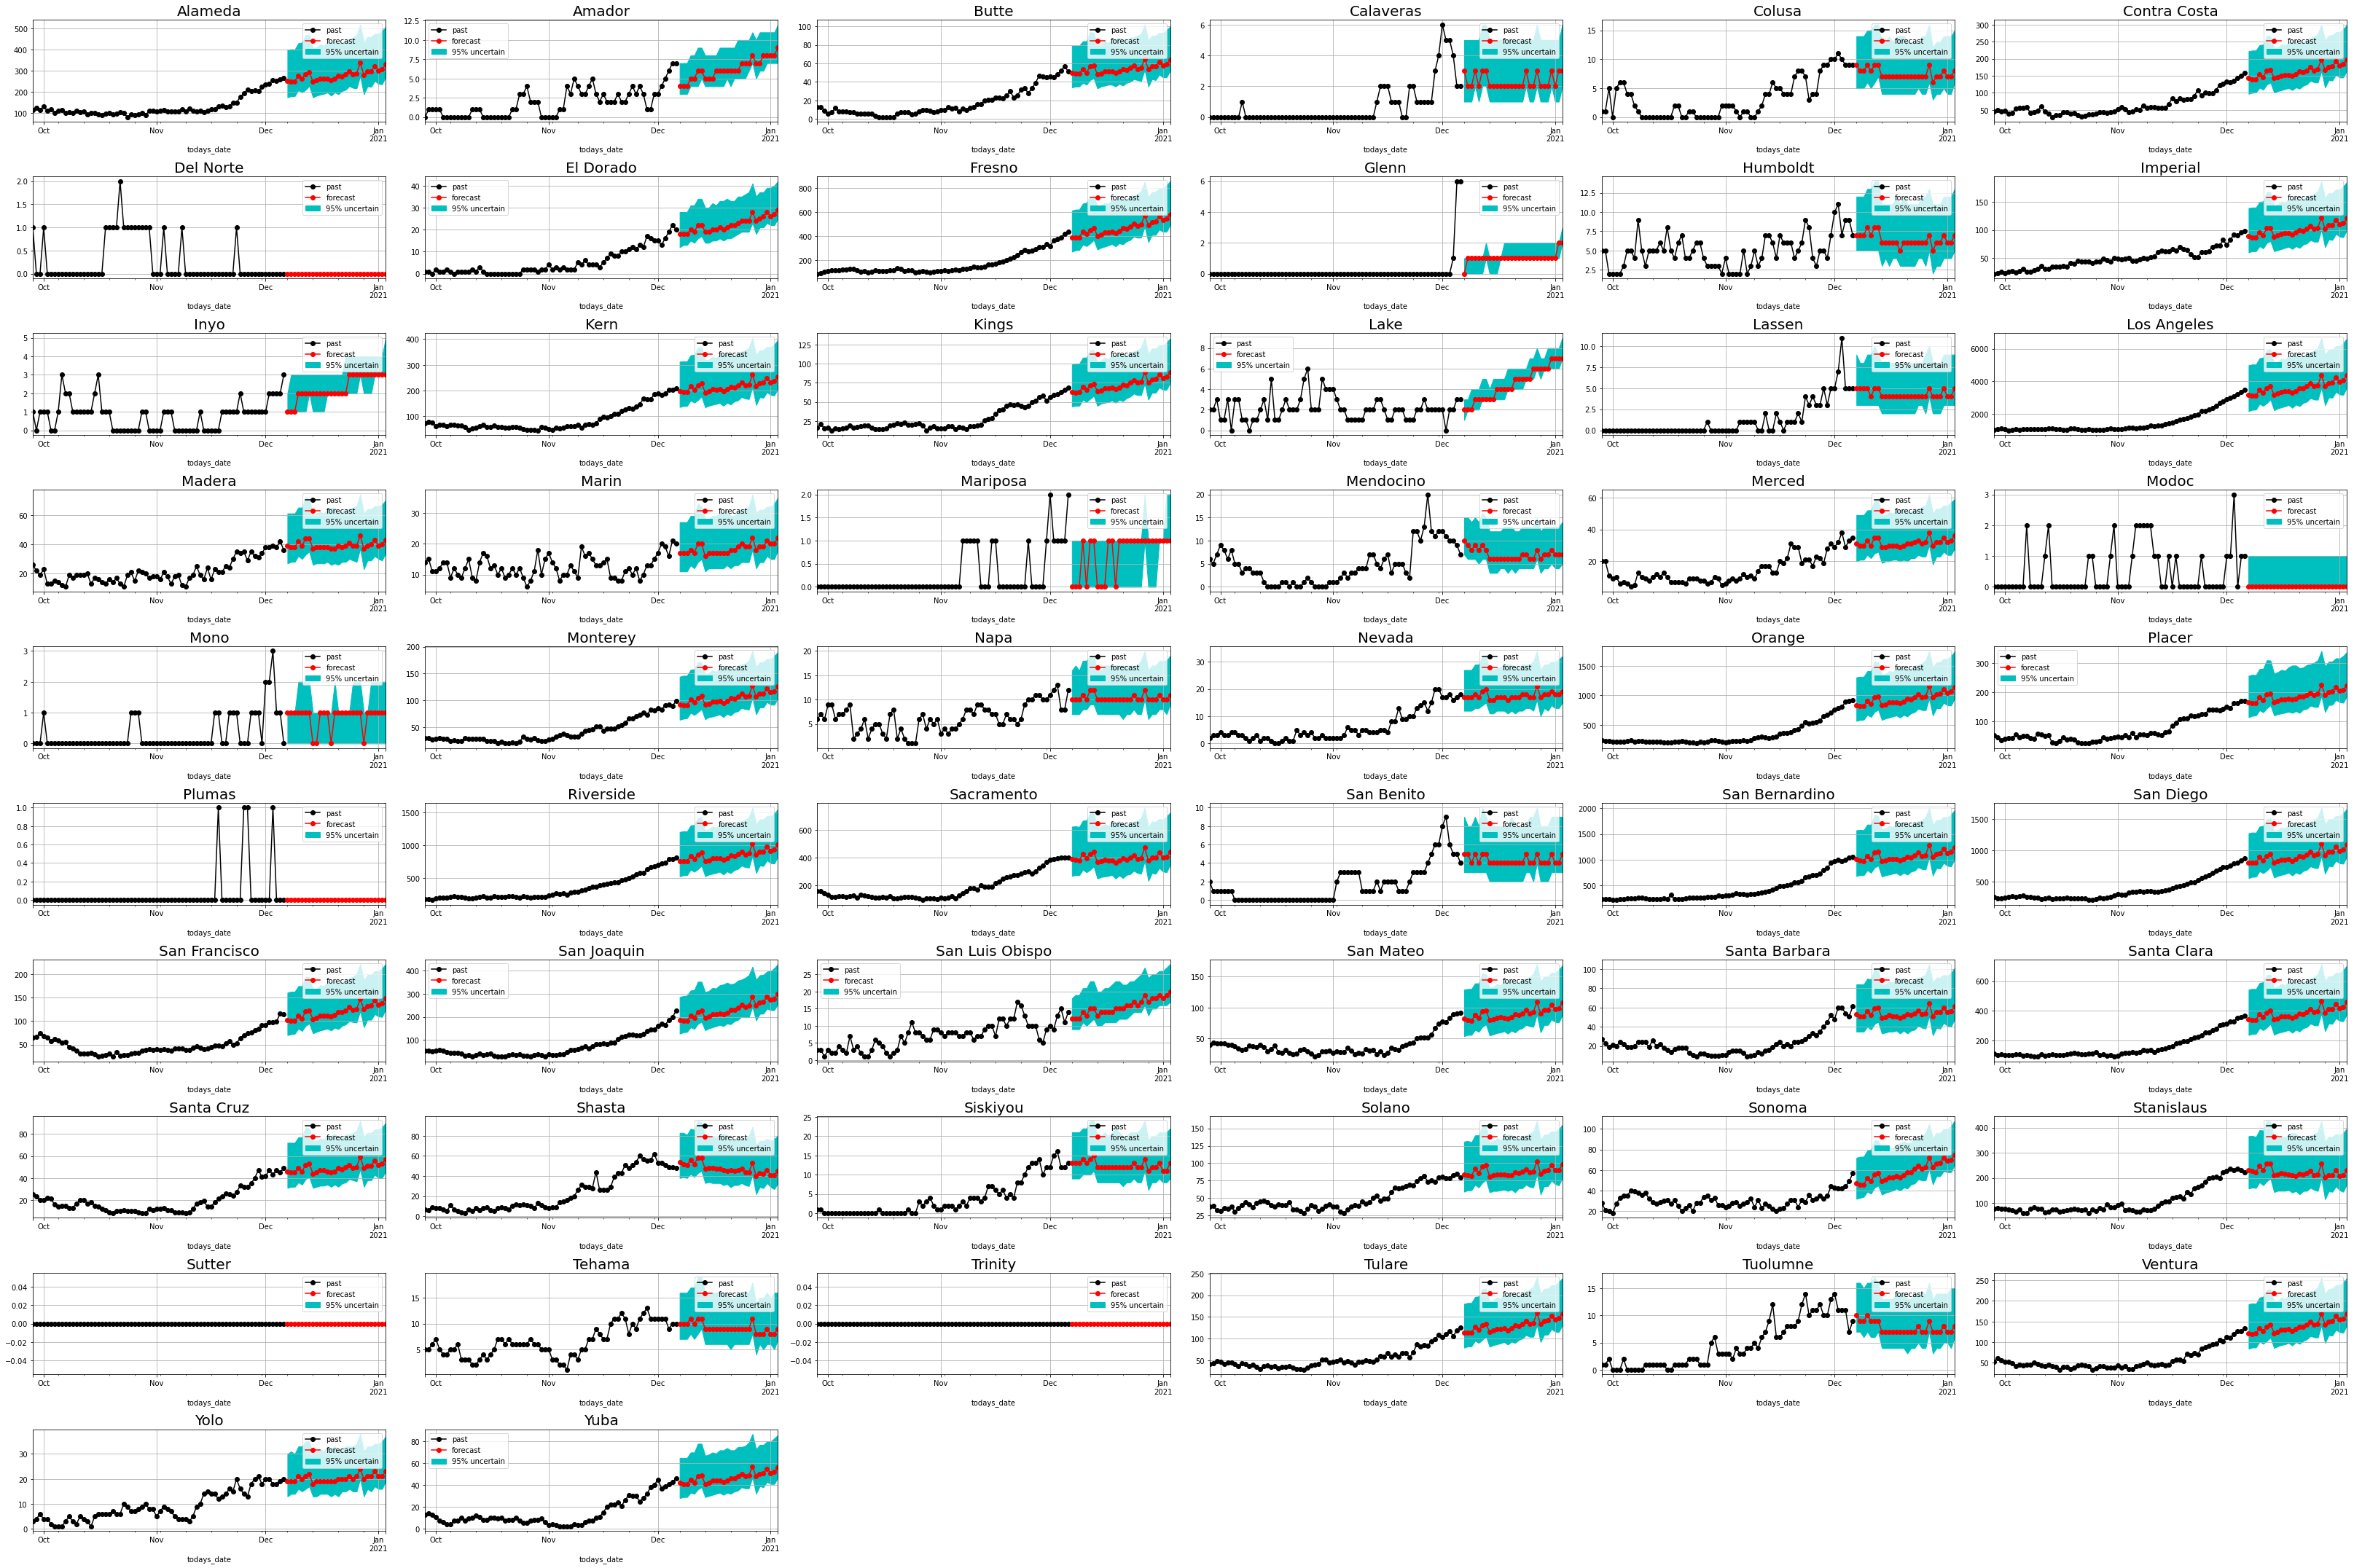

In [115]:
fig = plt.figure(figsize=(45,30))
for i, s in enumerate(past.columns, 1):
    ax = fig.add_subplot(10,6,i)
    ax = pd.concat([past,real],axis=0).plot(y=s, ax=ax, style='ko-', label='past')
#     ax = smoothed_hosps.plot(y=s, ax=ax, style='bo-', label='smoothed')
#     ax = local_pr.plot(y=s, ax=ax, style='go-', label='trend')
#     ax = smoothed_pr.plot(y=s, ax=ax, style='yo-', label='smoothed_pr')
    ax = mid_pr.plot(y=s, ax=ax, style='ro-', label='forecast')
    ax.fill_between(x=mid_pr.index, y1=low_pr[s].values, y2=high_pr[s].values, color='c', label='95% uncertain')
    ax.set_title(s, fontsize=20)
    ax.legend()
    ax.grid('on')
fig.tight_layout()

In [116]:
fig.savefig(f'dumps/cal/visual-{end_date:%Y-%m-%d}.png')

ValueError: Invalid format specifier

In [105]:
np.sum(np.abs(mid_pr.iloc[:7] - real).values)/  np.sum(np.abs(real).values)

0.21684388040930658

## Submission

In [54]:
five, fifty, ninefive = pr[:,0].cpu().unbind(dim=1)

low_var = (fifty - five) / 1.645
high_var = (ninefive - fifty) / 1.645
quantiles = np.array((0.01, 0.025) + tuple([0.05*i for i in range(1,10)]))
zp = norm.ppf(np.array(quantiles))
lowers = fifty.unsqueeze(dim=-1) + low_var.unsqueeze(dim=-1) * zp
highers = fifty.unsqueeze(dim=-1) - high_var.unsqueeze(dim=-1) * np.flip(zp, axis=0)

final_pr = pt.cat([lowers, fifty.unsqueeze(dim=-1), highers], dim=-1)

In [55]:
quantiles = np.r_[quantiles, [0.5], np.flip(1-quantiles, axis=0)]

In [56]:
len(quantiles)

23

In [57]:
target = "{} day ahead inc hosp"
fc_date = f"{pd.to_datetime(end_date)-pd.Timedelta(1,unit='d'):%Y-%m-%d}"
counties = past.columns
sub = defaultdict(list)
for i, county in enumerate(counties):
    days = range(28)
    fc = final_pr[i]
    fc = np.sort(fc, axis=0)
    for d in days:
        sub['forecast_date'].append(fc_date)
        sub['target'].append(target.format(d+1))
        sub['target_end_date'].append(f"{pd.to_datetime(end_date)+pd.Timedelta(d,unit='d'):%Y-%m-%d}")
        sub['location'].append(fips.loc[county, 'fips'])
        sub['type'].append('point')
        sub['quantile'].append('NA')
        sub['value'].append(fc[d, (len(quantiles)-1)//2])
        for j,q in enumerate(quantiles):
            sub['forecast_date'].append(fc_date)
            sub['target'].append(target.format(d+1))
            sub['target_end_date'].append(f"{pd.to_datetime(end_date)+pd.Timedelta(d,unit='d'):%Y-%m-%d}")
            sub['location'].append(fips.loc[county, 'fips'])
            sub['type'].append('quantile')
            sub['quantile'].append(f"{q:.3f}".rstrip('0'))
            sub['value'].append(fc[d,j])
sub = pd.DataFrame(sub)

In [58]:
sub.to_csv(f'dumps/cal/submission-{end_date}.csv')

## Debugging

In [11]:
import torch as pt
from torch.nn import functional as F

In [12]:
self = model

In [13]:
hosps_data = valid_data['hosps_data']
cases_data = valid_data['cases_data']

In [14]:
smoothed_hosps, hosps_local_pr = model.hosps_smoother(hosps_data)
smoothed_cases, cases_local_pr = model.cases_smoother(cases_data)

In [15]:
hosps_length = hosps_data.size(1)
attn_mask = pt.ones(
    hosps_length-self.cond_size+1,
    hosps_length-self.cond_size-self.pred_size+1,
    dtype=pt.bool, device=hosps_data.device,
).triu()
attn_mask = attn_mask.view(1, *attn_mask.shape, 1)
target_index = pt.tensor(
    np.arange(self.cond_size, hosps_length+1).reshape(-1,1)\
    + np.arange(self.pred_size * self.n_rolls).reshape(1,-1),
    dtype=pt.long, device=hosps_data.device,
)
target_mask = target_index >= hosps_length
target_index = pt.where(target_mask, pt.zeros_like(target_index)-1, target_index)
target = hosps_data[:, target_index]

In [16]:
smoothed_query = smoothed_hosps
smoothed_ref = pt.cat([smoothed_hosps, smoothed_cases], dim=0)
test_size = 0
smoothed_query = smoothed_query[:, -(test_size+self.cond_size):]
attn_mask = attn_mask[:, -(test_size+1):]
target = target[:, -(test_size+1):]
target_mask = target_mask[-(test_size+1):]
hosps_local_pr = hosps_local_pr[:, -(test_size+1):]

In [17]:
query = smoothed_query
ref = smoothed_ref

In [18]:
q_input = pt.cumsum(query, dim=1).unsqueeze(dim=1)
q, q_offset, q_scale = self.attention.minmax_conv1d(
    x=q_input,
    w=self.attention.q_weight,
    b=self.attention.q_bias,
)
q = q.transpose(1,2)
q_scale = q_scale.transpose(1,2)

In [19]:
rs = []
for r in pt.split(hosps_local_pr, self.attention.pred_size, dim=2):
    n, l, d = r.size()
    r = r / q_scale
    r = r.unsqueeze(dim=2).expand(n,l,self.attention.n_output,d)
    r = r.contiguous().view(n,l,-1)
    rs.append(r)

In [20]:
k_input = pt.cumsum(ref, dim=1).unsqueeze(dim=1)
k_input = k_input[..., :-self.attention.pred_size]
k, k_offset, k_scale = self.attention.minmax_conv1d(
    x=k_input, 
    w=self.attention.k_weight, 
    b=self.attention.k_bias, 
)
k = k.transpose(1,2)

In [21]:
v_input = ref.unsqueeze(dim=1)
v_input = v_input[..., self.attention.cond_size:]
# [N, 1, K-C] -> [N, K-P-C+1, H] 
v, _, _ = self.attention.minmax_conv1d(
    x=v_input, 
    w=self.attention.v_weight,
    b=self.attention.v_bias, 
    offset=pt.zeros_like(k_offset),
    scale=k_scale,
)
v = v.transpose(1,2)
v = F.relu(v)

In [22]:
full_score = self.attention._rbf(q, k)
r_score = -pt.sum((q - q) ** 2, dim=-1, keepdim=True)

In [23]:
preds = []
ps = []
biases = []

In [24]:
for skip in range(self.n_rolls):
    skip_size = self.pred_size * skip
    score = full_score[..., :(full_score.size(2)-skip_size), :]
    value = v[:, skip_size:]
    
    ref_score, max_idx_per_ref = score.max(dim=2)
    v_idx = max_idx_per_ref.view(-1, max_idx_per_ref.size(-1)).transpose(0, 1)
    v_idx = v_idx.unsqueeze(dim=-1).repeat(1,1,self.attention.d_hidden)
    
    selected_v = pt.gather(value, 1, v_idx).transpose(0, 1).view(
        *full_score.shape[:2],
        value.shape[0],
        self.attention.d_hidden,
    )
    selected_v = F.linear(selected_v, self.attention.o_weight, self.attention.o_bias)
    selected_v = F.relu(selected_v)
    
    ref_score = pt.cat([ref_score, r_score], dim=-1)
    f_score = ref_score.div(self.attention.temperature).softmax(dim=-1)
    f_score = pt.masked_fill(f_score, pt.isnan(f_score), 0.0)
    
    ref_score, r_score = f_score.split([f_score.size(-1)-1, 1], dim=-1)
    bias = r_score * rs[skip]
    p = ref_score.unsqueeze(dim=-1).mul(selected_v).sum(dim=-2)
    pr = p + bias
    
    pr = pr.view(*pr.shape[:-1], self.n_output, self.pred_size)
    preds.append(pr)
    p = p.view(*p.shape[:-1], self.n_output, self.pred_size)
    bias = bias.view(*bias.shape[:-1], self.n_output, self.pred_size)
    ps.append(p)
    biases.append(bias)

In [43]:
bias[0,0,1]

tensor([0.0960, 0.0974, 0.0988, 0.1002, 0.1016, 0.1030, 0.1043],
       device='cuda:1', grad_fn=<SelectBackward>)

In [44]:
p[0,0,1]

tensor([0.0191, 0.0201, 0.0209, 0.0790, 0.0266, 0.0575, 0.0567],
       device='cuda:1', grad_fn=<SelectBackward>)

In [62]:
pr = pt.cat(preds, dim=3)
pr = pr * q_scale.unsqueeze(dim=2)
pr = pr.detach()

In [63]:
pr[:,0,1]

tensor([[131.4660, 129.9935, 134.3328,  ..., 196.3530, 246.2356, 247.1077],
        [  2.4197,   2.4238,   2.4819,  ...,   3.2958,   3.6176,   3.6451],
        [ 23.1777,  22.5247,  23.1965,  ...,  29.0725,  43.6654,  43.4061],
        ...,
        [ 64.3197,  64.8707,  68.3061,  ..., 142.4064, 171.3652, 173.5207],
        [ 12.3584,  12.1134,  11.9793,  ...,  18.4389,  28.3534,  28.4270],
        [ 15.3480,  14.9524,  15.4471,  ...,  21.5796,  35.9002,  35.8421]],
       device='cuda:1')

In [25]:
skip = 0
skip_size = self.pred_size * skip
score = full_score[..., :(full_score.size(2)-skip_size), :]
value = v[:, skip_size:]

ref_score, max_idx_per_ref = score.max(dim=2)
v_idx = max_idx_per_ref.view(-1, max_idx_per_ref.size(-1)).transpose(0, 1)
v_idx = v_idx.unsqueeze(dim=-1).repeat(1,1,self.attention.d_hidden)

selected_v = pt.gather(value, 1, v_idx).transpose(0, 1).view(
    *full_score.shape[:2],
    value.shape[0],
    self.attention.d_hidden,
)
transformed_v = F.linear(selected_v, self.attention.o_weight, self.attention.o_bias)
transformed_v = F.relu(transformed_v)

ref_score = pt.cat([ref_score, r_score], dim=-1)
f_score = ref_score.div(self.attention.temperature).softmax(dim=-1)
f_score = pt.masked_fill(f_score, pt.isnan(f_score), 0.0)

ref_score, r_score = f_score.split([f_score.size(-1)-1, 1], dim=-1)
bias = r_score * rs[skip]
p = ref_score.unsqueeze(dim=-1).mul(transformed_v).sum(dim=-2)
pr = p + bias

pr = pr.view(*pr.shape[:-1], self.n_output, self.pred_size)
p = p.view(*p.shape[:-1], self.n_output, self.pred_size)
bias = bias.view(*bias.shape[:-1], self.n_output, self.pred_size)

In [26]:
full_score

tensor([[[0.0011, 0.0044, 0.0025,  ..., 0.0016, 0.0024, 0.0038]],

        [[0.0002, 0.0011, 0.0006,  ..., 0.0003, 0.0005, 0.0009]],

        [[0.0020, 0.0073, 0.0043,  ..., 0.0029, 0.0042, 0.0063]],

        ...,

        [[0.0013, 0.0053, 0.0030,  ..., 0.0019, 0.0029, 0.0046]],

        [[0.0028, 0.0091, 0.0057,  ..., 0.0038, 0.0055, 0.0080]],

        [[0.0039, 0.0111, 0.0073,  ..., 0.0052, 0.0071, 0.0099]]],
       device='cuda:1', grad_fn=<SplitWithSizesBackward>)

In [77]:
pr = pr * q_scale.unsqueeze(dim=2)

In [ ]:
w = self.attention.k_weight
x = k_input
ksize = w.size(-1)
length = x.size(-1)
# [N, D, T] -> [N, D, K, T-K+1]
x = pt.stack(
    [x[...,i:i+ksize] for i in range(length-ksize+1)],
    dim=-1,
)
# offset = pt.zeros_like(k_offset)
offset = k_offset
scale = k_scale
scale[scale.eq(0.0)] = 1.0
# x = x.sub(offset.unsqueeze(dim=2)).div(scale.unsqueeze(dim=2))

In [63]:
w = self.attention.v_weight
b = self.attention.v_bias
x = v_input
ksize = w.size(-1)
length = x.size(-1)
# [N, D, T] -> [N, D, K, T-K+1]
x = pt.stack(
    [x[...,i:i+ksize] for i in range(length-ksize+1)],
    dim=-1,
)
offset = pt.zeros_like(k_offset)
# off set = k_offset
scale = k_scale
scale[scale.eq(0.0)] = 1.0
x = x.sub(offset.unsqueeze(dim=2)).div(scale.unsqueeze(dim=2))
y = w.unsqueeze(dim=-1).mul(x.unsqueeze(dim=1)).sum(dim=3).sum(dim=2)
if b is not None:
    y = y + b.unsqueeze(dim=-1)

In [177]:
xx = F.linear(y.transpose(1,2), self.attention.o_weight, self.attention.o_bias)

In [189]:
x_before = x[:,0].transpose(1,2)
x_after = xx[...,7:14]